In [1]:
# 대용량 데이터 학습 : 대용량 데이터를 기계학습에 사용할 경우 메모리 부족 문제가 발생할 수 있음
# 서버 용량 증설
# 학습용 데이터를 적게 설정
# 분산 처리 시스템(hadoop, spark)

from sklearn import datasets
import numpy as np

iris = datasets.load_iris()

X = iris.data
y = iris.target

In [2]:
# 데이터 섞기
idx = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

params = {
    "hidden_layer_sizes": [(10,), (50,), (100,), (10, 10), (50, 50), (100, 100)],
    "activation": ["tanh", "relu"],
    "alpha": [0.0001, 0.01],
}

model = MLPClassifier(random_state=0, max_iter=5000)
clf = GridSearchCV(model, param_grid=params, cv=3)
clf.fit(X, y)

print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

0.9733333333333333
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=5000,
              random_state=0)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# generator →  메모리는 절약할 수 있지만 실행시간이 더 오래 걸릴 수 있음


def make_numbers(n):
    while n < 6:
        yield n
        # yield : 메모리에 저장X, 호출한 곳으로 값을 바로 전달(return과 비슷한 역할)
        n += 1


for i in make_numbers(0):
    print(i)

0
1
2
3
4
5


In [7]:
import sys

# 리스트의 데이터가 늘어나면 메모리 사용량이 증가한다.
# 리스트의 모든 데이터를 메모리에 적재

a = [i for i in range(100)]
print(sys.getsizeof(a))  # getsizeof() → 바이트크기를 계산

b = [i for i in range(1000)]
print(sys.getsizeof(b))

# generator expression : 위에서 언급한 generator 함수를 좀더 쉽게 사용할 수 있도록 제공되는 표현식
# 리스트[] 대신 ()을 사용 → 모든 데이터를 메모리에 적재하지 않고 next() 함수를 통해 조금씩 메모리에 적재, 메모리를 효율적으로 사용할 수 있다

c = (i for i in range(100))
print(sys.getsizeof(c))

d = (i for i in range(1000))
print(sys.getsizeof(d))

920
8856
192
192


In [8]:
import time


def func_sleep(x):
    print("1초 멈춤....")
    time.sleep(1)
    return x


# 리스트
items1 = [func_sleep(x) for x in range(5)]
items1

1초 멈춤....
1초 멈춤....
1초 멈춤....
1초 멈춤....
1초 멈춤....


[0, 1, 2, 3, 4]

In [9]:
# 리스트 사용 → 리스트의 모든 원소를 한꺼번에 처리한 후 최종 결과가 출력됨(5개의 메모리 생성)

for i in items1:
    print(i)

0
1
2
3
4


In [10]:
# generator생성
items2 = (func_sleep(y) for y in range(5))
items2

<generator object <genexpr> at 0x000001F074F8EE90>

In [11]:
# generator를 사용하면 수행 시간이 긴 연산을 한꺼번에 수행하지 않고 조금씩 수행함

for i in items2:
    print(i)

1초 멈춤....
0
1초 멈춤....
1
1초 멈춤....
2
1초 멈춤....
3
1초 멈춤....
4


In [12]:
print("리스트 활용, 메모리 사용량:", sys.getsizeof(items1))
print("generator 활용, 메모리 사용량:", sys.getsizeof(items2))

리스트 활용, 메모리 사용량: 120
generator 활용, 메모리 사용량: 208


In [13]:
# 일반적인 방식(한꺼번에 처리하는 방식)

from sklearn.metrics import accuracy_score

clf = MLPClassifier(max_iter=5000, random_state=0)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.9666666666666667

In [14]:
# batch(X_train, y_train, 10)
# 전체 데이터를 보내지 않고 10개씩 조금씩 보내서 처리하는 방식


def batch(X1, y1, n):
    x_size = len(X1)
    for idx in range(0, x_size, n):
        yield X1[idx : min(idx + n, x_size)], y1[idx : min(idx + n, x_size)]


# 10개씩 12회로 나누어 처리하는 방식
clf2 = MLPClassifier(random_state=0)

# 시간은 더 오래 걸릴 수 있으나 메모리를 절약할 수 있는 방법
points_tr = []
points_te = []
samp = batch(X_train, y_train, 10)

for idx, (chunk_X, chunk_y) in enumerate(samp):
    print(idx)
    # 부분적으로 학습, 처음에는 정확도가 낮지만 점차 향상됨
    clf2.partial_fit(chunk_X, chunk_y, classes=[0, 1, 2])

    pred = clf2.predict(X_train)
    point = accuracy_score(y_train, pred)
    points_tr.append(point)
    print("학습용 :", point)

    pred = clf2.predict(X_test)
    point = accuracy_score(y_test, pred)
    points_te.append(point)
    print("검증용 :", point)

0
학습용 : 0.48333333333333334
검증용 : 0.5
1
학습용 : 0.525
검증용 : 0.5333333333333333
2
학습용 : 0.6416666666666667
검증용 : 0.6333333333333333
3
학습용 : 0.725
검증용 : 0.7
4
학습용 : 0.7833333333333333
검증용 : 0.7333333333333333
5
학습용 : 0.825
검증용 : 0.7666666666666667
6
학습용 : 0.8416666666666667
검증용 : 0.7666666666666667
7
학습용 : 0.8333333333333334
검증용 : 0.8
8
학습용 : 0.85
검증용 : 0.8
9
학습용 : 0.8583333333333333
검증용 : 0.8
10
학습용 : 0.8583333333333333
검증용 : 0.8
11
학습용 : 0.8583333333333333
검증용 : 0.8


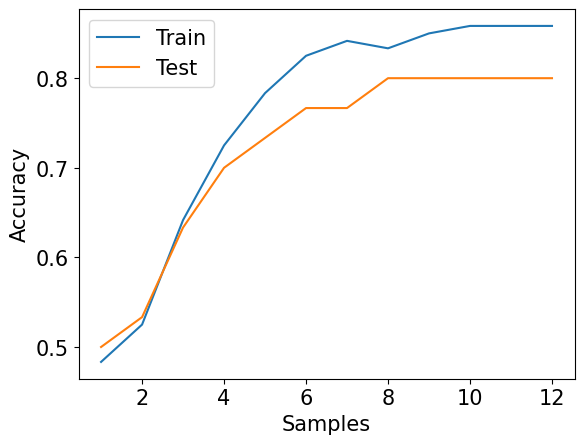

In [15]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 15
plt.plot(range(1, 13), points_tr, label="Train")
plt.plot(range(1, 13), points_te, label="Test")
plt.ylabel("Accuracy")
plt.xlabel("Samples")
plt.legend()